## Read data

This tutorial jupyter notebook and the ``sample.npz`` it uses can be found at [https://github.com/timpyrkov/mhealthdata/tree/master/docs/notebook](https://github.com/timpyrkov/mhealthdata/tree/master/docs/notebook).

Many smartphone health apps have their own data format. 

``mHealthData`` is a tool to load to pandas Dataframes all basic health data (`steps`, `sleep`, `bpm`, ``rhr``, and `weight`) from different formats (``.csv``, ``.json``, ``.xml`` stored in various sub-folders as well as equispaced or with arbitrary timestamps for start and end). 

The code cell below is an example. It will only run if you provide a valid ``path`` to a health data export and replace `FitbitLoader()` with `ShealthLoader()` for Samsung Health export or `HealthkitLoader()` for Apple Healthkit export.

Tutorial does not include a raw data export. If you have one, please uncomment the commented lines in two cells below and run the piece of code to read data. Tutorial provides a randomly generated ``sample.npz`` to show examples of data analysis and visualization after it were read and converted to NumPy arrays.

In [1]:
import mhealthdata

# path = '/Users/username/Downloads/wearable_data/User/'
# wdata = mhealthdata.FitbitLoader(path)

# """ Show userdata """
# print(wdata.userdata)

# """ Show loaded devices """

# print(wdata.devices)

# """ Show lodaded dataframes """
# print(wdata.dataframes)

# """ Show 'steps' dataframe """
# print(wdata.df['steps'].head())


## Data to NumPy

Device key `all` is default. You may want to gete data separately for `wearable`
 or `mobile`, or even for `iPhone` or `Apple Watch` if those were found.

`get_device_data()` method converts data for specific wearable or mobile device to a dictionary of NumPy arrays.

`save_device_npz()` method saves data for specific wearable or mobile device to `.npz` files for furthur use e.g. in another notebook (the `.npz` file is less then 25Mb for a 2-year sample).

A saved data sample can be loaded using NumPy.

In [2]:
# """ Get data for 'all' devices """
# data = wdata.get_device_data('all')

# """ Or save data to an .npz file """
# wdata.save_device_npz('all')

In [3]:
import numpy as np

""" Open a saved 'sample.npz' """
data = np.load('sample.npz')

""" List loaded NumPy arrays """
for key in data:
    print(key, data[key].shape, data[key].dtype)

idate (28,) int64
steps (28, 1440) float64
sleep (28, 1440) float64
bpm (28, 1440) float64
rhr (28,) float64
weight (28,) float64


## Date and time

Date is stored as `idate` is ordinal date - number of days since January 1st of year 1.

Time is given in the number of minutes since midnight 0 - 1440 as the index along the second axis for 2D arrays (`steps`, `sleep`, `bpm`).

Datetime python lib modules `datetime` and `timedelta` can be used to convert `idate` to human-readable date-time format.


In [4]:
from datetime import datetime, timedelta

idates = data['idate'] # ordinal days (January 1st of year 1 - is day 1)
dates = [datetime.fromordinal(d) for d in idates]
print(f'Date range {dates[0]} - {dates[-1]}')

Date range 2021-02-01 00:00:00 - 2021-02-28 00:00:00


## Visualization

Intraday data visualiztion is simple. 

For `bpm` we observe gaps in data when `bpm` drops to zero when a user took off their wristband.

For `steps` zero values indicate both missing data and not-walking, e.g. during sleep.

For `sleep` zero values indicate not sleeping.

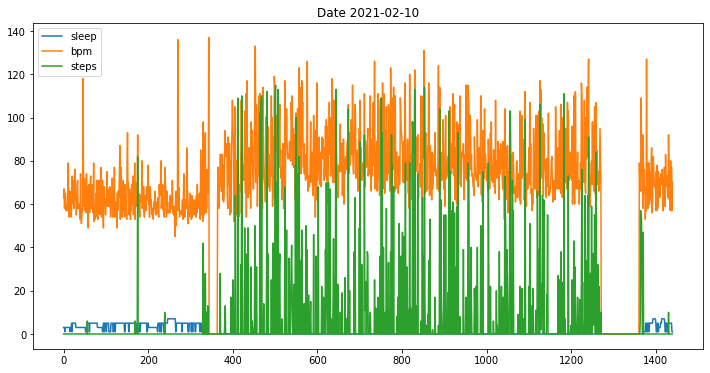

In [5]:
import pylab as plt

i = 9 # Day 10 has index 9
plt.figure(figsize=(12,6), facecolor='white')
plt.title(f'Date {dates[i].strftime("%Y-%m-%d")}')
for dname in ['sleep', 'bpm', 'steps']:
        plt.plot(data[dname][i], label=dname)
plt.legend()
plt.show()


## Sleep duration

Bouts of `sleep` bouts are often split between two days.

Utility fiunction `find_nonzero_intervals()` returns list of indices of start and end of a  continuous non-zero range (e.g. sleep bout) along the flattened `sleep` array.

In [6]:
sleep = data['sleep'].flatten()
bouts = mhealthdata.find_nonzero_intervals(sleep)
duration = [bout[1] - bout[0] for bout in bouts]
print('Sleep duration [minutes]:', duration)

Sleep duration [minutes]: [360, 410, 428, 398, 421, 450, 426, 457, 406, 431, 393, 479, 434, 306, 156, 399, 475, 420, 379, 406, 369, 292, 155, 416, 128, 299, 401, 325, 315, 116]


## Sleep stages

Utility fiunction `sleep_stage_dict()` returns dictionary to decode numerically-coded sleep stages.

Let us plot sleep stages for a sleep bout between Feb 9th and 10th.

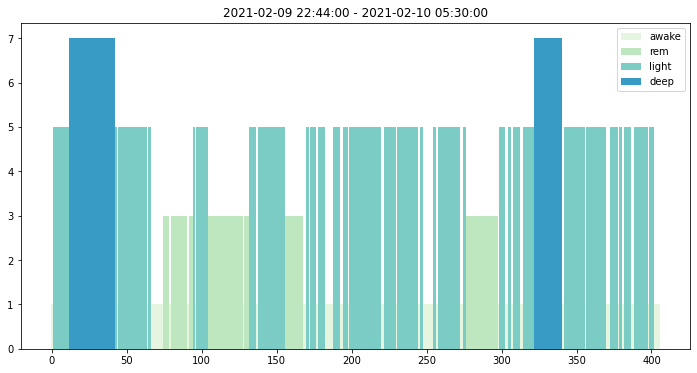

In [7]:
j0, j1 = bouts[8] # Day 9 has index 8
x = sleep[j0:j1]
t = np.arange(len(x))

date_time_start = dates[j0 // 1440] + timedelta(minutes = j0 % 1440)
date_time_end = dates[j1 // 1440] + timedelta(minutes = j1 % 1440)

stages = mhealthdata.sleep_stage_dict()

plt.figure(figsize=(12,6), facecolor='white')
plt.title(f'{date_time_start} - {date_time_end}')
for x_ in np.unique(x):
    mask = x == x_
    label = stages[x_]
    color = plt.cm.GnBu(0.1 * x_)
    plt.bar(t[mask], x[mask], width=1, color=color, label=label)
plt.legend()
plt.show()

## Data correlation

Visual inspection tells us that `rhr` and `weight` are correlated. 

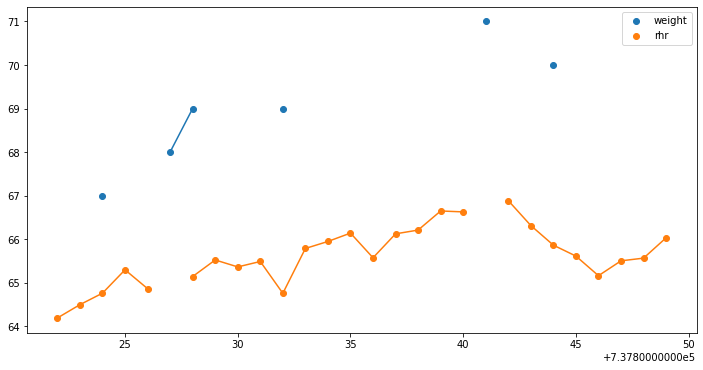

In [8]:
x = data['weight']
y = data['rhr']
t = data['idate']

""" IMPORTANT: zero values indicate missing data and should be disregarded """
x[x == 0] = np.nan
y[y == 0] = np.nan

plt.figure(figsize=(12,6), facecolor='white')

plt.plot(t, x) # plot lines
plt.scatter(t, x, label='weight') # plot dots

plt.plot(t, y) # plot lines
plt.scatter(t, y, label='rhr') # plot dots

plt.legend()
plt.show()

## Data interpolation

Missing data reduce the number of overlapping data-points. Technically low number of data-points results in correlation coefficient `r` with poor statistical significance `p-value ~ 0.25`. Statistically significant result shoud have `p-value < 0.05`.

We will use interpolation data to fill the gaps and improve the statistical significance. 

A study [Pyrkov T.V. et al., Nature Communications 12, 2765 (2021)](https://www.nature.com/articles/s41467-021-23014-1) shows high consistency of recovery rates in quite different biological signals - physical activity measured by consumer wearable devices and laboratory blood cell counts. The typical recovery time of 1-2 weeks. The finding suggests it may be safe to use averaging windows or impute data gaps of several day length (though both affect noise and correlation and therefore should be used with caution).

In [9]:
from scipy.stats import pearsonr

x = data['rhr']
y = data['weight']
t = data['idate']

""" IMPORTANT: zero values indicate missing data and should be disregarded """
mask = (x > 0) & (y > 0)
r, p = pearsonr(x[mask], y[mask])
print(f'Correlation {r:.2f}, P-value {p:.2g}')

""" Interpolate rhr data """
mask = (x > 0)
x_ = np.interp(t, t[mask], x[mask])
print('\nMissing RHR data imputed with linear interpolation\n')

mask = (x_ > 0) & (y > 0)
r, p = pearsonr(x_[mask], y[mask])
print(f'Correlation {r:.2f}, P-value {p:.2g}')


Correlation 0.75, P-value 0.25

Missing RHR data imputed with linear interpolation

Correlation 0.87, P-value 0.024
